In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from plotnine import *

In [2]:
d = pd.read_csv('rank_runs_summary.csv')

d

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc_test,pick_KL_div_test,training_lists,test_lists,data_size,test_size,extra_info,score_name,p_continue,generative_noise_scale,scoring_noise_scale,run_i,rand_seed
0,uci wine example,Stan inspection model,0.350741,0.351510,0.670117,1.113015,100,2000,6497,6017,"{""est_p_continue"": 0.7281110827499999}",quality,0.8,0.87,2.0,0,518677876
1,uci wine example,Stan list utility model,0.387958,0.389079,0.686442,0.865139,100,2000,6497,6017,NaN,quality,0.8,0.87,2.0,0,518677876
2,uci wine example,Stan difference utility model,0.389250,0.390633,0.685934,0.932345,100,2000,6497,6017,NaN,quality,0.8,0.87,2.0,0,518677876
3,uci wine example,"logistic differences, early stop=T",0.265737,0.268926,0.694939,0.445618,100,2000,6497,6017,NaN,quality,0.8,0.87,2.0,0,518677876
4,uci wine example,"logistic differences, early stop=F",0.405049,0.406714,0.715179,0.416367,100,2000,6497,6017,NaN,quality,0.8,0.87,2.0,0,518677876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,uci wine example,Stan difference utility model,0.360354,0.360628,0.688663,0.980665,100,2000,6497,6014,NaN,quality,0.8,0.87,2.0,19,364254565
136,uci wine example,"logistic differences, early stop=T",0.163518,0.157298,0.707201,0.415069,100,2000,6497,6014,NaN,quality,0.8,0.87,2.0,19,364254565
137,uci wine example,"logistic differences, early stop=F",0.367699,0.368227,0.725284,0.406310,100,2000,6497,6014,NaN,quality,0.8,0.87,2.0,19,364254565
138,uci wine example,logistic items,0.375449,0.376438,0.721841,0.409710,100,2000,6497,6014,NaN,quality,0.8,0.87,2.0,19,364254565


In [3]:
n_draws = int(np.max(d['run_i']) + 1)
n_lists = int(np.mean(d['training_lists']))

In [4]:
d_SpearmanR = d.loc[:, ['estimate_name', 'pick_auc_test', 'SpearmanR_test']].reset_index(drop=True, inplace=False)
d_SpearmanR['is_Stan_model'] = [nm.startswith('Stan ') for nm in d_SpearmanR['estimate_name']]
ideal_score = d_SpearmanR.loc[d_SpearmanR['estimate_name'] == 'observed score', 'SpearmanR_test'].mean()
d_SpearmanR = d_SpearmanR.loc[d_SpearmanR['estimate_name'] != 'observed score', :]

d_SpearmanR

,estimate_name,pick_auc_test,SpearmanR_test,is_Stan_model
0,Stan inspection model,0.670117,0.351510,True
1,Stan list utility model,0.686442,0.389079,True
2,Stan difference utility model,0.685934,0.390633,True
3,"logistic differences, early stop=T",0.694939,0.268926,False
4,"logistic differences, early stop=F",0.715179,0.406714,False
...,...,...,...,...
134,Stan list utility model,0.694350,0.372636,True
135,Stan difference utility model,0.688663,0.360628,True
136,"logistic differences, early stop=T",0.707201,0.157298,False
137,"logistic differences, early stop=F",0.725284,0.368227,False


In [5]:
model_breaks = [
    'Stan inspection model',
    'Stan list utility model',
    'Stan difference utility model',
    'logistic differences, early stop=T',
    'logistic differences, early stop=F',
    'logistic items',
]
model_labels = [
    'Stan sequential inspection',
    'Stan list utility',
    'Stan pair utility',
    'logistic differences, early stop',
    'logistic differences',
    'logistic items',
]

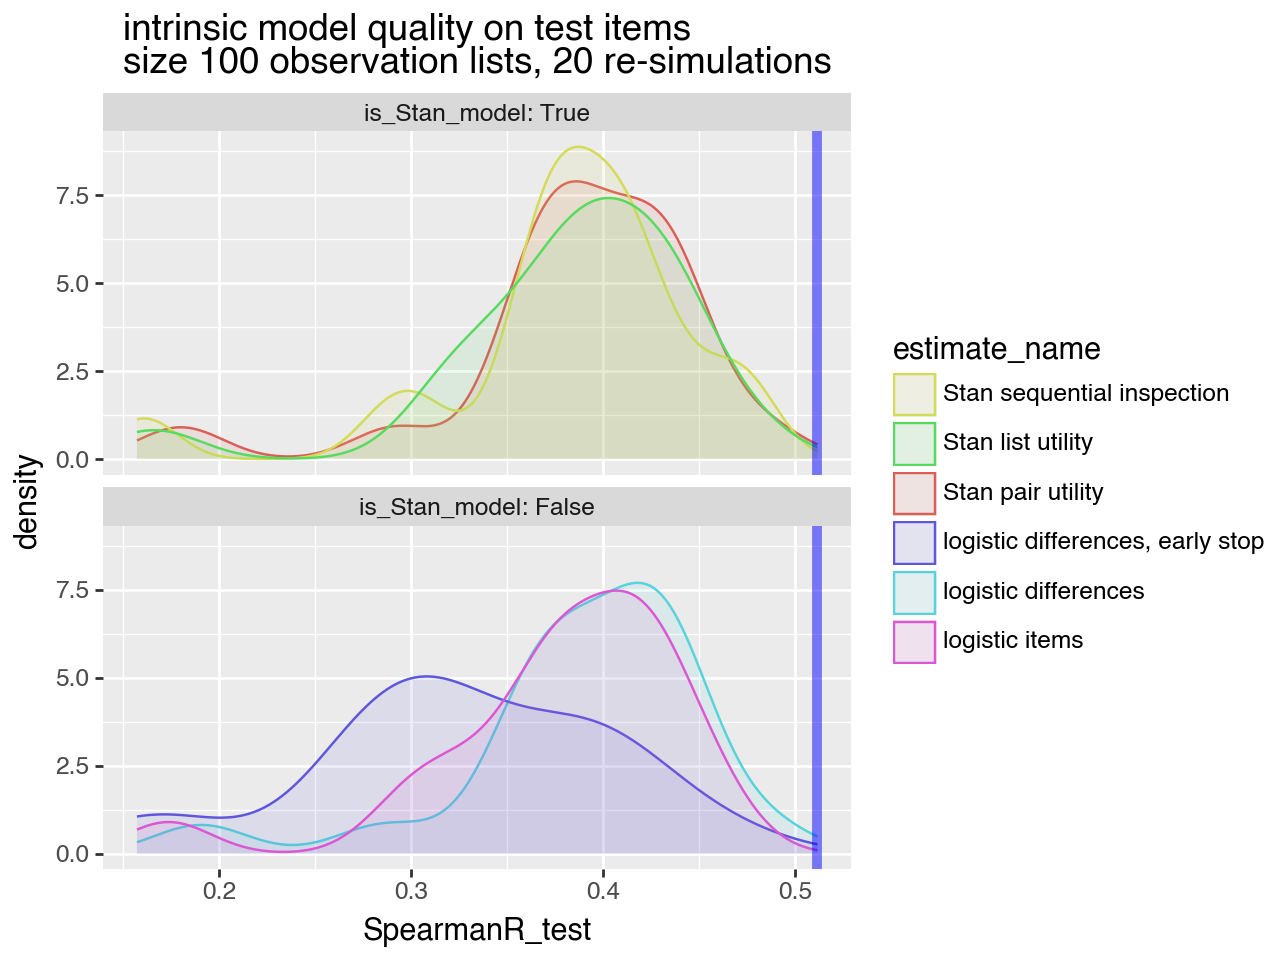

In [6]:
(
    ggplot(
        data=d_SpearmanR,
        mapping=aes(
            x='SpearmanR_test',
            color='estimate_name',
            fill='estimate_name',
        )
    )
    + facet_wrap(
        'is_Stan_model', 
        ncol=1, 
        labeller='label_both',
        as_table=False,
        )
    + geom_density(alpha=0.1)
    + scale_color_discrete(breaks=model_breaks, labels=model_labels)
    + scale_fill_discrete(breaks=model_breaks, labels=model_labels)
    + geom_vline(xintercept=ideal_score, color='blue', alpha=0.5, size=2)
    + ggtitle(f"intrinsic model quality on test items\nsize {n_lists} observation lists, {n_draws} re-simulations")
)

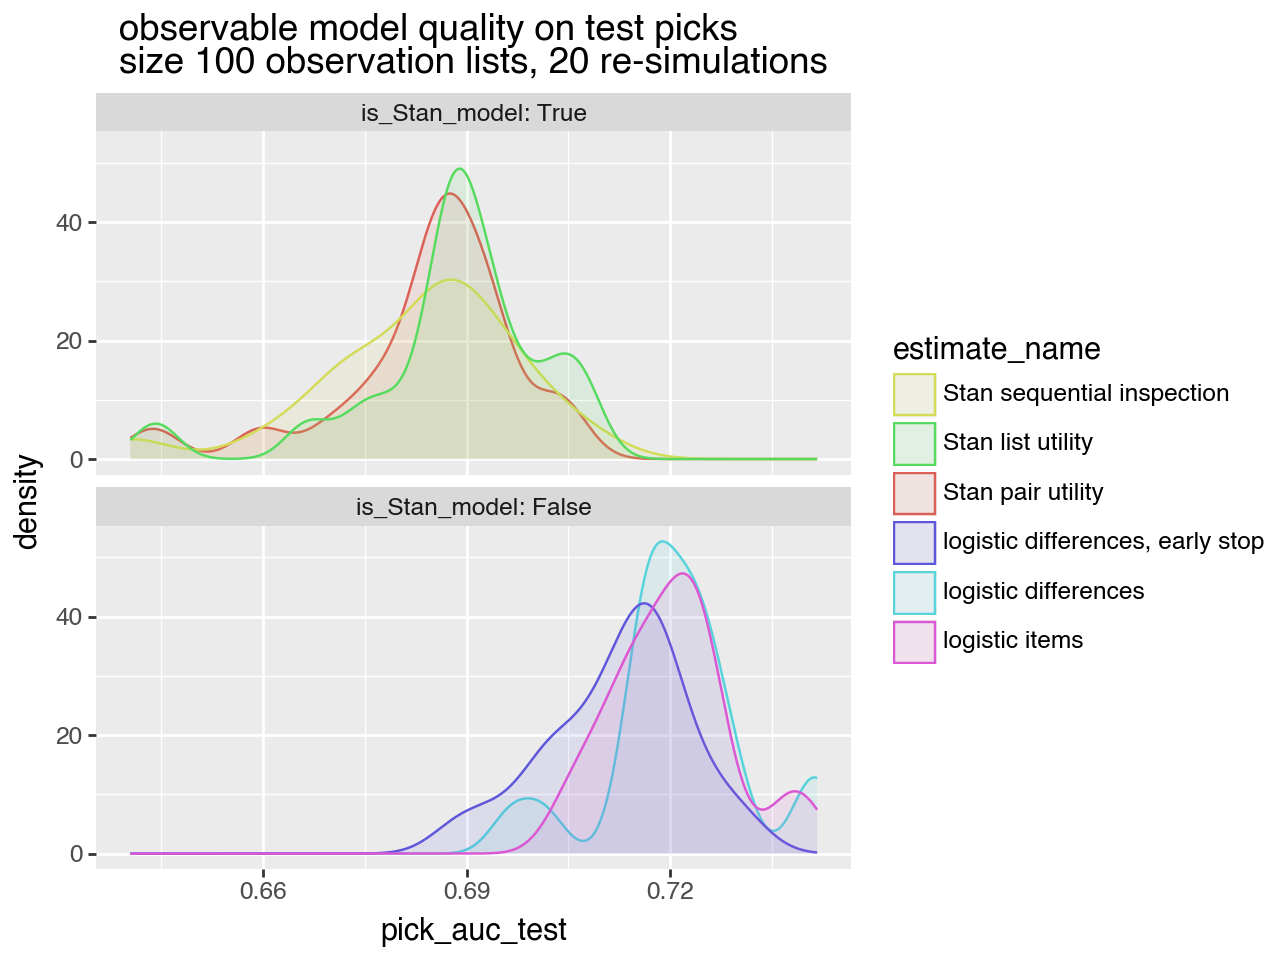

In [7]:

(
    ggplot(
        data=d_SpearmanR,
        mapping=aes(
            x='pick_auc_test',
            color='estimate_name',
            fill='estimate_name',
        )
    )
    + facet_wrap(
        'is_Stan_model', 
        ncol=1, 
        labeller='label_both',
        as_table=False,
        )
    + geom_density(alpha=0.1)
    + scale_color_discrete(breaks=model_breaks, labels=model_labels)
    + scale_fill_discrete(breaks=model_breaks, labels=model_labels)
    + ggtitle(f"observable model quality on test picks\nsize {n_lists} observation lists, {n_draws} re-simulations")
)

In [8]:
de = d.loc[d['estimate_name'] == 'Stan inspection model', ['test_lists', 'extra_info']].reset_index(drop=True, inplace=False)
de['est_p_continue'] = [json.loads(v)['est_p_continue'] for v in de['extra_info']]
de.head()

,test_lists,extra_info,est_p_continue
0,2000,"{""est_p_continue"": 0.7281110827499999}",0.728111
1,2000,"{""est_p_continue"": 0.778187189}",0.778187
2,2000,"{""est_p_continue"": 0.78881087}",0.788811
3,2000,"{""est_p_continue"": 0.7503556772500001}",0.750356
4,2000,"{""est_p_continue"": 0.7314193687500001}",0.731419


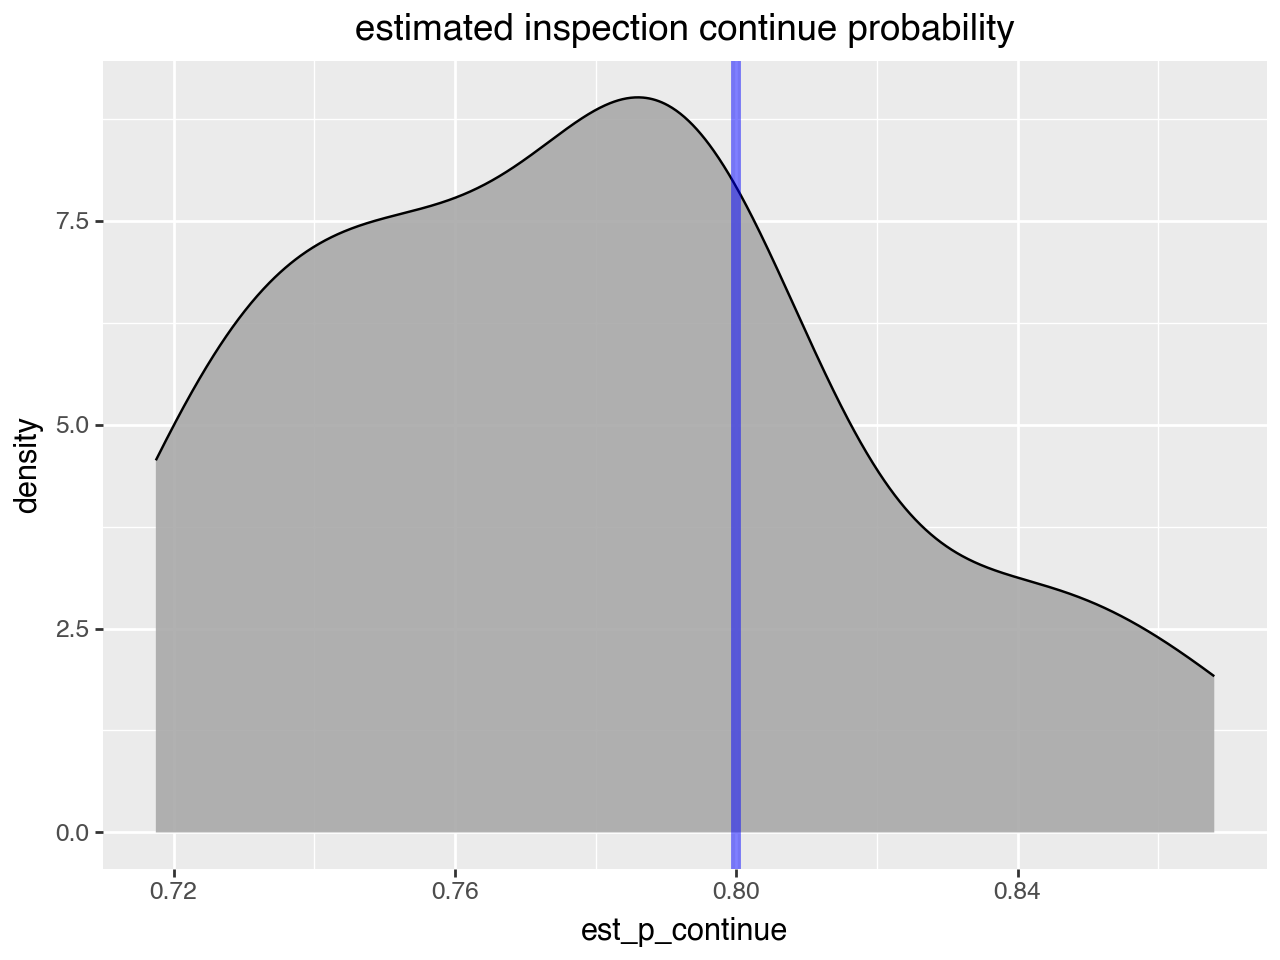

In [9]:
(
    ggplot(
        data=de,
        mapping=aes(x='est_p_continue')
    )
    + geom_density(fill='darkgrey', alpha=0.9)
    + geom_vline(xintercept=np.mean(d['p_continue']), color='blue', size=2, alpha=0.5)
    + ggtitle("estimated inspection continue probability")
)

